In [7]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from torch.optim import SGD, Adam
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
class Encoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims) < 2:
            raise ValueError("Inputs list has to be at least length:2")

        self.layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.layers.append(nn.Linear(dims[i], dims[i + 1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
        x = self.layers[-1](x)
        x = x / torch.sqrt(2 * torch.mean(x**2))
        return x


class Decoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        if len(dims) < 2:
            raise ValueError("Inputs list has to be at least lenght:2")
        self.layers = nn.ModuleList()
        for i in range(len(dims) - 1):
            self.layers.append(nn.Linear(dims[i], dims[i + 1]))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))

        x = F.log_softmax(self.layers[-1](x), dim=-1)
        return x

In [9]:
M = 16 # number of constellation points
flag_train_model = True # True: train model, False: load pre-trained model
Path = "./ae_miso_rayleigh_16qam.pth"
encoder = Encoder([M, 64, 64, 64, 8]).to(device)
decoder = Decoder([8, 512, 512, 512, M]).to(device)

In [10]:
if not flag_train_model:
    # read model if exists else train model
    checkpoint = torch.load(Path, map_location=torch.device('cpu'))
    encoder.load_state_dict(checkpoint["Encoder"])
    decoder.load_state_dict(checkpoint["Decoder"])
    print("Model loaded")

epoch=9999: 100%|██████████| 10000/10000 [03:32<00:00, 47.13it/s]


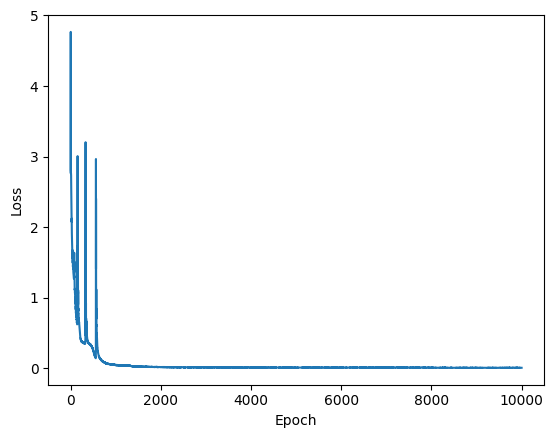

Model saved


In [11]:
if flag_train_model:
    train_snr = 15 # training SNR in dB
    criterion = nn.NLLLoss()     # negative log likelihood loss
    para = list(encoder.parameters()) + list(decoder.parameters())  # get all parameters
    opt = Adam(para, lr=0.01)
    loss = []  # store the loss value
    totEpoch = int(1e4)  # total number of epochs
    iteration = tqdm(range(totEpoch), desc="loss")

    for iterator in iteration:
        iteration.set_description("epoch={:}".format(iterator))
        messages = torch.randint(0, M, size=(51200,), device=device)  # generate
        one_hot = F.one_hot(messages, M).float()  # convert to one hot encoding shape=(16000, M)
        tx =encoder(one_hot)

        tx_real = tx[:, np.arange(0,4)].view(-1,2,2)
        tx_imag = tx[:, np.arange(4,8)].view(-1,2,2)
        ch_real = torch.randn((messages.shape[0], 1, 2), device=device) / torch.sqrt(torch.tensor(2.0, device=device))
        ch_imag = torch.randn((messages.shape[0], 1, 2), device=device) / torch.sqrt(torch.tensor(2.0, device=device))
        rx_real = torch.bmm(ch_real, tx_real) - torch.bmm(ch_imag, tx_imag)
        rx_imag = torch.bmm(ch_imag, tx_real) + torch.bmm(ch_real, tx_imag)

        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1,4)

        sigma = np.sqrt(0.5/(np.power(10, train_snr/10)))
        noise = (sigma * torch.randn(rx.shape, device=device))
        rx = rx + noise

        csi = torch.cat([ch_real, ch_imag], axis=-2).view(-1,4)

        y_pred = decoder(torch.cat([rx, csi], axis=-1))

        cross_entropy = criterion(y_pred, messages)

        opt.zero_grad()
        cross_entropy.backward()
        opt.step()

        loss.append(cross_entropy.item())


    # plot the loss
    plt.figure()
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the model
    torch.save({
            'Encoder': encoder.state_dict(),
            'Decoder': decoder.state_dict(),
            }, Path)
    print("Model saved")



In [14]:
# Monte-Carlo simulation for SER
SER = np.array([])
SNR_arr = np.arange(0, 24, 2)
iteration = tqdm(range(len(SNR_arr)), desc="loss")
for iterator in iteration:
    test_snr = SNR_arr[iterator]
    iteration.set_description("SNR={:.1f}dB".format(test_snr))
    totErr = 0
    totSym = 0
    minErr = 1e3
    maxSym = minErr * 1e4
    minSym = minErr * 1e2
    while totErr < minErr and totSym < maxSym or totSym < minSym:
        batch = 40
        messages = np.arange(M) # 0, 1, 2,..., M-1
        messages = np.tile(messages, batch) # 0, 1, 2,..., M-1, 0, 1, 2,..., M-1, ...
        test_labels = to_categorical(messages) # one-hot encoding

        ch_real = (torch.randn((M * batch, 1, 2)) / np.sqrt(2)).to(device)
        ch_imag = (torch.randn((M * batch, 1, 2)) / np.sqrt(2)).to(device)

        test_data = torch.from_numpy(test_labels).to(device)
        test_label = torch.from_numpy(messages).to(device)

        tx = encoder(test_data)
        tx_real = tx[:, np.arange(0, 4)].view(-1, 2, 2)
        tx_imag = tx[:, np.arange(4, 8)].view(-1, 2, 2)

        rx_real = torch.bmm(ch_real, tx_real) - torch.bmm(ch_imag, tx_imag)
        rx_imag = torch.bmm(ch_imag, tx_real) + torch.bmm(ch_real, tx_imag)

        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1, 4)

        sigma = np.sqrt(0.5 / (np.power(10, test_snr / 10)))
        noise = (sigma * torch.randn(rx.shape)).to(device)
        rx = rx + noise

        csi = torch.cat([ch_real, ch_imag], axis=-2).view(-1, 4)

        rx_csi = torch.cat([rx, csi], axis=-1)
        y_pred = decoder(rx_csi)

        classification = torch.argmax(y_pred, axis=-1).to("cpu").detach().numpy()

        correct = np.equal(classification, messages)

        totSym = totSym + correct.shape[0]
        totErr = totErr + correct.shape[0] - np.sum(correct)

    SER = np.append(SER, totErr / totSym)

SNR=22.0dB: 100%|██████████| 12/12 [00:33<00:00,  2.79s/it]


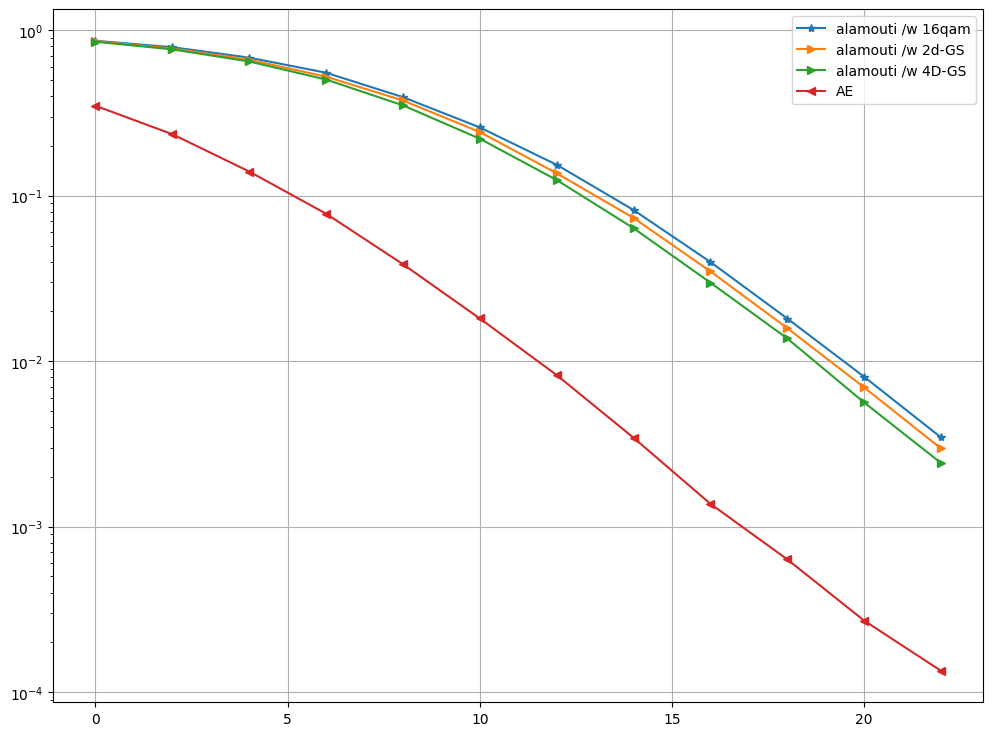

In [15]:
baseline_2dGS = np.array(
    [
        0.8582738919,
        0.77518119729,
        0.6638753775,
        0.5241933032,
        0.3764218117,
        0.2427,
        0.1367,
        0.07344675006,
        0.03492563936,
        0.0158441070,
        0.0069469963,
        0.0029697814,
    ]
)

baseline_4dGS = np.array(
    [
        0.8525,
        0.7667,
        0.6476,
        0.5039,
        0.3517,
        0.2212,
        0.1245,
        0.06367,
        0.02986,
        0.01373,
        0.005634,
        0.002427,
    ]
)

baseline_16qam = np.array(
    [
        0.863982915109450,
        0.789824218750000,
        0.683372881355932,
        0.553873626373626,
        0.394372549019608,
        0.258779977466602,
        0.153877394636015,
        0.082014608979925,
        0.039804998762683,
        0.018117047197906,
        0.008057689702067,
        0.003462703794546,
    ]
)

plt.figure(figsize=(12, 9))
# plt.semilogy(np.arange(0,23,2), baseline_QPSK,'-*', label='Alamouti w/ QPSK')

plt.semilogy(np.arange(0, 24, 2), baseline_16qam, "-*", label="alamouti /w 16qam")
plt.semilogy(np.arange(0, 24, 2), baseline_2dGS, "->", label="alamouti /w 2d-GS ")
plt.semilogy(np.arange(0, 24, 2), baseline_4dGS, "->", label="alamouti /w 4D-GS ")
plt.semilogy(np.arange(0, 24, 2), SER, "-<", label="AE")

# , SNR_array, SER, '-o'
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Tx sym, Ant 2, T2')

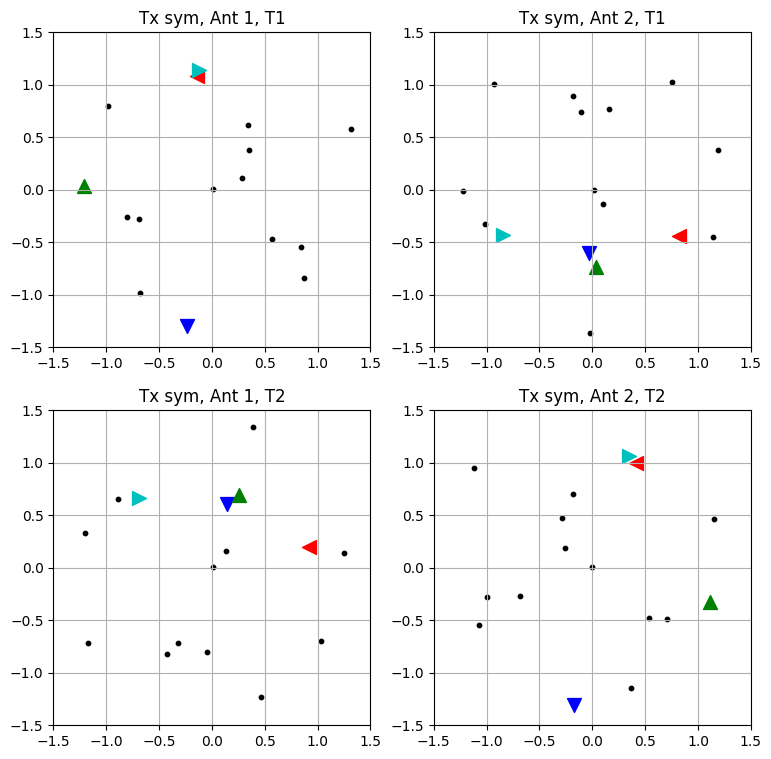

In [16]:
batch = 400
messages = np.arange(M)
messages = np.tile(messages, batch)
test_labels = to_categorical(messages)

ch_real = (torch.randn((M * batch, 2, 1)) / np.sqrt(2)).to(device)
ch_imag = (torch.randn((M * batch, 2, 1)) / np.sqrt(2)).to(device)

test_data = torch.from_numpy(test_labels).to(device)
test_label = torch.from_numpy(messages).to(device)

transmitted_signals = encoder(test_data).to("cpu").detach().numpy()

s1 = transmitted_signals[:, 0] + 1j * transmitted_signals[:, 4]
s2 = transmitted_signals[:, 1] + 1j * transmitted_signals[:, 5]
s3 = transmitted_signals[:, 2] + 1j * transmitted_signals[:, 6]
s4 = transmitted_signals[:, 3] + 1j * transmitted_signals[:, 7]

a = 0  #### rotation angles should be carefully find for every different realization
s1 = s1 * np.exp(1j * np.pi * a / 4)
s2 = s2 * np.exp(1j * np.pi * a / 4)
s3 = s3 * np.exp(1j * np.pi * a / 4)
s4 = s4 * np.exp(1j * np.pi * a / 4)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
for axe in [ax1, ax2, ax3, ax4]:
    axe.grid(True)
    axe.set_xlim([-1.5, 1.5])
    axe.set_ylim([-1.5, 1.5])
#     axe.set_xlabel('Real')
#     axe.set_ylabel('Imaginary')


color_map = [
    "r",
    "b",
    "g",
    "r",
    "c",
    "m",
    "y",
    "k",
    "w",
    "r",
    "b",
    "g",
    "r",
    "c",
    "m",
    "y",
    "k",
    "w",
]
marker_style = [
    "o",
    "v",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    "*",
    "h",
    "H",
    "D",
    "d",
    "P",
    "X",
    "o",
]

ax1.scatter(s1[0:16].real, s1[0:16].imag, c="k", s=10)
ax3.scatter(s2[0:16].real, s2[0:16].imag, c="k", s=10)
ax2.scatter(s3[0:16].real, s3[0:16].imag, c="k", s=10)
ax4.scatter(s4[0:16].real, s4[0:16].imag, c="k", s=10)
for i in np.arange(1, 5):
    ax1.scatter(s1[i].real, s1[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax3.scatter(s2[i].real, s2[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax2.scatter(s3[i].real, s3[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax4.scatter(s4[i].real, s4[i].imag, c=color_map[i], s=100, marker=marker_style[i])

ax1.set_title("Tx sym, Ant 1, T1")
ax2.set_title("Tx sym, Ant 2, T1")
ax3.set_title("Tx sym, Ant 1, T2")
ax4.set_title("Tx sym, Ant 2, T2")
